# Structure

1. Get Data
2. Preprocess Data
3. Split the data
4. Create Checkpoint
5. Build and Fit the model
6. Evaluate Model
7. Load saved model
8. Make Predictions
9. Plot predictions

# 1. Get Data

In [6]:
# Import Dependencies
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [42]:
df = pd.read_csv('/content/S&P.csv',parse_dates=["Date"],index_col=["Date"])

In [43]:
df.head()

,Open,High,Low,Close
Date,,,,
2023-02-13,"4,096.62","4,138.90","4,092.67","4,137.29"
2023-02-10,"4,068.92","4,094.36","4,060.79","4,090.46"
2023-02-09,"4,144.25","4,156.23","4,069.67","4,081.50"
2023-02-08,"4,153.47","4,156.85","4,111.67","4,117.86"
2023-02-07,"4,105.35","4,176.54","4,088.39","4,164.00"


In [44]:
def replace(x):
  word_ls = []
  for char in x:
    if char != ',':
      word_ls.append(char)
  return ''.join(word_ls)

In [45]:
import re
df['Close'] = df['Close'].map(lambda x : replace(x))

In [46]:
df.head()

,Open,High,Low,Close
Date,,,,
2023-02-13,"4,096.62","4,138.90","4,092.67",4137.29
2023-02-10,"4,068.92","4,094.36","4,060.79",4090.46
2023-02-09,"4,144.25","4,156.23","4,069.67",4081.50
2023-02-08,"4,153.47","4,156.85","4,111.67",4117.86
2023-02-07,"4,105.35","4,176.54","4,088.39",4164.00


# 2 . Preprocess Data

In [47]:
# Get bitcoin date array
timesteps = df.index.to_numpy()
prices = df.iloc[:,3].to_numpy(dtype=float)
prices

array([4137.29, 4090.46, 4081.5 , 4117.86, 4164.  , 4111.08, 4136.48,
       4179.76, 4119.21, 4076.6 , 4017.77, 4070.56, 4060.43, 4016.22,
       4016.95, 4019.81, 3972.61, 3898.85, 3928.86, 3990.97, 3999.09,
       3983.17, 3969.61, 3919.25, 3892.09, 3895.08, 3808.1 , 3852.97,
       3824.14, 3839.5 , 3849.28, 3783.22, 3829.25, 3844.82, 3822.39,
       3878.44, 3821.62, 3817.66, 3852.36, 3895.75, 3995.32, 4019.65,
       3990.56, 3934.38, 3963.51, 3933.92, 3941.26, 3998.84, 4071.7 ,
       4076.57, 4080.11, 3957.63, 3963.94, 4026.12, 4027.26, 4003.58,
       3949.94, 3965.34, 3946.56, 3958.79, 3991.73, 3957.25, 3992.93,
       3956.37, 3748.57, 3828.11, 3806.8 , 3770.55, 3719.89, 3759.69,
       3856.1 , 3871.98, 3901.06, 3807.3 , 3830.6 , 3859.11, 3797.34,
       3752.75, 3665.78, 3695.16, 3719.98, 3677.95, 3583.07, 3669.91,
       3577.03, 3588.84, 3612.39, 3639.66, 3744.52, 3783.28, 3790.93,
       3678.43, 3585.62, 3640.47, 3719.04, 3647.29, 3655.04, 3693.23,
       3757.99, 3789

In [48]:
# Define Global Parameters
WINDOW_SIZE = 7
HORIZON = 1

In [49]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1
  Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [50]:
# Create function to view NumPy arrays as windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  """
  Turns a 1D array into a 2D array of sequential labelled windows of window_size with horizon size labels.
  """
  # 1. Create a window of specific window_size (add the horzion on the end for labelling later)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes, window_indexes.shape}")

  # 3. Index on the target array (a time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]
  # print(windowed_array)

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
  return windows, labels

In [51]:
# Make Windows and Labels
WINDOW_SIZE = 7
HORIZON = 1
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(244, 244)

# 3 . Split the Data

## For Plotting

In [52]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(200, 51, 200, 51)

## For the Model

In [53]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of winodws and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [54]:
# Create train and test windows 
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(195, 49, 195, 49)

# 4 . Create Model Checkpoint

In [55]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            monitor="val_loss",
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True)

# 5 . Build and Fit the Model

## Model 0 : Dense (Windows = 7, Horizon = 1)

In [56]:
train_windows

array([[4137.29, 4090.46, 4081.5 , ..., 4164.  , 4111.08, 4136.48],
       [4090.46, 4081.5 , 4117.86, ..., 4111.08, 4136.48, 4179.76],
       [4081.5 , 4117.86, 4164.  , ..., 4136.48, 4179.76, 4119.21],
       ...,
       [3991.24, 4123.34, 4146.87, ..., 4175.48, 4155.38, 4131.93],
       [4123.34, 4146.87, 4300.17, ..., 4155.38, 4131.93, 4287.5 ],
       [4146.87, 4300.17, 4175.48, ..., 4131.93, 4287.5 , 4183.96]])

In [57]:
# Set random Seed
tf.random.set_seed(42)

# Build the model
model_0 = tf.keras.Sequential([
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(HORIZON,activation='linear')
],name='model_1_Dense')

# Compile the model
model_0.compile(loss = 'mae',
                optimizer = 'adam',
                metrics = ['mae','mse'])

# Fit the model 
history_0 = model_0.fit(x=train_windows,
                        y=train_labels,
                        epochs = 100,
                        batch_size=128,
                        validation_data=(test_windows,test_labels),
                        callbacks = [create_model_checkpoint(model_name=model_0.name)])

Epoch 1/100
1/2 [==============>...............] - ETA: 0s - loss: 4526.6206 - mae: 4526.6206 - mse: 20526084.0000

2/2 [==============================] - 1s 618ms/step - loss: 4444.7886 - mae: 4444.7886 - mse: 19803800.0000 - val_loss: 4530.3486 - val_mae: 4530.3486 - val_mse: 20539726.0000
Epoch 2/100
1/2 [==============>...............] - ETA: 0s - loss: 4049.9160 - mae: 4049.9160 - mse: 16434371.0000

2/2 [==============================] - 0s 475ms/step - loss: 3975.3669 - mae: 3975.3669 - mse: 15843672.0000 - val_loss: 4019.5498 - val_mae: 4019.5498 - val_mse: 16170539.0000
Epoch 3/100
1/2 [==============>...............] - ETA: 0s - loss: 3586.6516 - mae: 3586.6516 - mse: 12891464.0000

2/2 [==============================] - 0s 449ms/step - loss: 3517.8933 - mae: 3517.8933 - mse: 12409491.0000 - val_loss: 3518.8508 - val_mae: 3518.8508 - val_mse: 12394294.0000
Epoch 4/100
1/2 [==============>...............] - ETA: 0s - loss: 3142.6360 - mae: 3142.6360 - mse: 9894087.0000

2/2 [==============================] - 0s 433ms/step - loss: 3069.8481 - mae: 3069.8481 - mse: 9454476.0000 - val_loss: 3027.4602 - val_mae: 3027.4602 - val_mse: 9175945.0000
Epoch 5/100
1/2 [==============>...............] - ETA: 0s - loss: 2710.4448 - mae: 2710.4448 - mse: 7365471.0000

2/2 [==============================] - 0s 480ms/step - loss: 2631.0176 - mae: 2631.0176 - mse: 6951493.0000 - val_loss: 2544.2483 - val_mae: 2544.2483 - val_mse: 6482649.0000
Epoch 6/100
1/2 [==============>...............] - ETA: 0s - loss: 2281.3591 - mae: 2281.3591 - mse: 5219825.5000

2/2 [==============================] - 0s 444ms/step - loss: 2197.9238 - mae: 2197.9238 - mse: 4858233.0000 - val_loss: 2069.8374 - val_mae: 2069.8374 - val_mse: 4292823.0000
Epoch 7/100
1/2 [==============>...............] - ETA: 0s - loss: 1845.5001 - mae: 1845.5001 - mse: 3416942.5000

2/2 [==============================] - 0s 459ms/step - loss: 1773.9766 - mae: 1773.9766 - mse: 3168557.0000 - val_loss: 1609.4656 - val_mae: 1609.4656 - val_mse: 2598336.7500
Epoch 8/100
1/2 [==============>...............] - ETA: 0s - loss: 1434.0491 - mae: 1434.0491 - mse: 2068182.1250

2/2 [==============================] - 0s 429ms/step - loss: 1361.5997 - mae: 1361.5997 - mse: 1874037.6250 - val_loss: 1150.7212 - val_mae: 1150.7212 - val_mse: 1332185.2500
Epoch 9/100
1/2 [==============>...............] - ETA: 0s - loss: 1016.7373 - mae: 1016.7373 - mse: 1043075.5000

2/2 [==============================] - 0s 449ms/step - loss: 948.9465 - mae: 948.9465 - mse: 918428.2500 - val_loss: 690.2673 - val_mae: 690.2673 - val_mse: 485060.7500
Epoch 10/100
1/2 [==============>...............] - ETA: 0s - loss: 612.5560 - mae: 612.5560 - mse: 385376.5000

2/2 [==============================] - 1s 690ms/step - loss: 535.0400 - mae: 535.0400 - mse: 306752.0312 - val_loss: 234.6763 - val_mae: 234.6763 - val_mse: 64434.5195
Epoch 11/100
1/2 [==============>...............] - ETA: 0s - loss: 191.1395 - mae: 191.1395 - mse: 46084.7227

2/2 [==============================] - 0s 484ms/step - loss: 151.2912 - mae: 151.2912 - mse: 33370.2812 - val_loss: 193.3076 - val_mae: 193.3076 - val_mse: 47979.4609
Epoch 12/100
2/2 [==============================] - 0s 51ms/step - loss: 241.4695 - mae: 241.4695 - mse: 70660.8750 - val_loss: 460.9524 - val_mae: 460.9524 - val_mse: 223753.9375
Epoch 13/100
2/2 [==============================] - 0s 35ms/step - loss: 451.1188 - mae: 451.1188 - mse: 215895.8281 - val_loss: 572.6337 - val_mae: 572.6337 - val_mse: 339464.3125
Epoch 14/100
2/2 [==============================] - 0s 50ms/step - loss: 531.6561 - mae: 531.6561 - mse: 293170.3438 - val_loss: 563.7857 - val_mae: 563.7857 - val_mse: 329372.5000
Epoch 15/100
2/2 [==============================] - 0s 37ms/step - loss: 508.4990 - mae: 508.4990 - mse: 269385.8125 - val_loss: 462.2914 - val_mae: 462.2914 - val_mse: 224956.6562
Epoch 16/100
2/2 [==============================] - 0s 52ms/step - loss: 405.4701 - mae: 405.4701 - mse: 17537

2/2 [==============================] - 0s 471ms/step - loss: 244.3848 - mae: 244.3848 - mse: 68943.6172 - val_loss: 89.9560 - val_mae: 89.9560 - val_mse: 14487.8984
Epoch 18/100
2/2 [==============================] - 0s 50ms/step - loss: 94.6561 - mae: 94.6561 - mse: 13665.0039 - val_loss: 164.5288 - val_mae: 164.5288 - val_mse: 34548.2852
Epoch 19/100
2/2 [==============================] - 0s 49ms/step - loss: 152.2215 - mae: 152.2215 - mse: 32134.1699 - val_loss: 269.6928 - val_mae: 269.6928 - val_mse: 82436.1250
Epoch 20/100
2/2 [==============================] - 0s 56ms/step - loss: 232.0402 - mae: 232.0402 - mse: 63168.9453 - val_loss: 272.2254 - val_mae: 272.2254 - val_mse: 83798.2266
Epoch 21/100
2/2 [==============================] - 0s 66ms/step - loss: 220.0426 - mae: 220.0426 - mse: 57770.7031 - val_loss: 190.8542 - val_mae: 190.8542 - val_mse: 44822.0000
Epoch 22/100
2/2 [==============================] - 0s 47ms/step - loss: 135.7267 - mae: 135.7267 - mse: 27027.5645 - val

2/2 [==============================] - 1s 680ms/step - loss: 126.8450 - mae: 126.8450 - mse: 21355.4453 - val_loss: 82.8759 - val_mae: 82.8759 - val_mse: 10759.9756
Epoch 27/100
2/2 [==============================] - 0s 61ms/step - loss: 85.3882 - mae: 85.3882 - mse: 10882.3555 - val_loss: 109.9642 - val_mae: 109.9642 - val_mse: 16261.6748
Epoch 28/100
2/2 [==============================] - 0s 65ms/step - loss: 88.6902 - mae: 88.6902 - mse: 14065.7266 - val_loss: 140.7309 - val_mae: 140.7309 - val_mse: 26244.2422
Epoch 29/100
2/2 [==============================] - 0s 60ms/step - loss: 109.0435 - mae: 109.0435 - mse: 19239.7930 - val_loss: 122.3536 - val_mae: 122.3536 - val_mse: 20180.3691
Epoch 30/100
2/2 [==============================] - 0s 69ms/step - loss: 90.2852 - mae: 90.2852 - mse: 14201.9580 - val_loss: 90.3459 - val_mae: 90.3459 - val_mse: 11050.6885
Epoch 31/100
1/2 [==============>...............] - ETA: 0s - loss: 78.2098 - mae: 78.2098 - mse: 10087.5518

2/2 [==============================] - 1s 646ms/step - loss: 77.7217 - mae: 77.7217 - mse: 9748.9062 - val_loss: 82.7763 - val_mae: 82.7763 - val_mse: 10604.5361
Epoch 32/100
1/2 [==============>...............] - ETA: 0s - loss: 87.7332 - mae: 87.7332 - mse: 10707.2090

2/2 [==============================] - 0s 430ms/step - loss: 86.4018 - mae: 86.4018 - mse: 10779.4795 - val_loss: 82.7720 - val_mae: 82.7720 - val_mse: 11051.7119
Epoch 33/100
2/2 [==============================] - 0s 35ms/step - loss: 88.0748 - mae: 88.0748 - mse: 11092.9893 - val_loss: 83.4246 - val_mae: 83.4246 - val_mse: 10078.3955
Epoch 34/100
2/2 [==============================] - 0s 34ms/step - loss: 78.0681 - mae: 78.0681 - mse: 9378.6445 - val_loss: 93.5245 - val_mae: 93.5245 - val_mse: 11839.3682
Epoch 35/100
2/2 [==============================] - 0s 36ms/step - loss: 77.9897 - mae: 77.9897 - mse: 10642.4844 - val_loss: 110.8553 - val_mae: 110.8553 - val_mse: 16522.3281
Epoch 36/100
2/2 [==============================] - 0s 43ms/step - loss: 84.9020 - mae: 84.9020 - mse: 12857.4424 - val_loss: 105.6246 - val_mae: 105.6246 - val_mse: 15051.7217
Epoch 37/100
2/2 [==============================] - 0s 34ms/step - loss: 79.6896 - mae: 79.6896 - mse: 11317.4111 - val_loss: 89.5754 

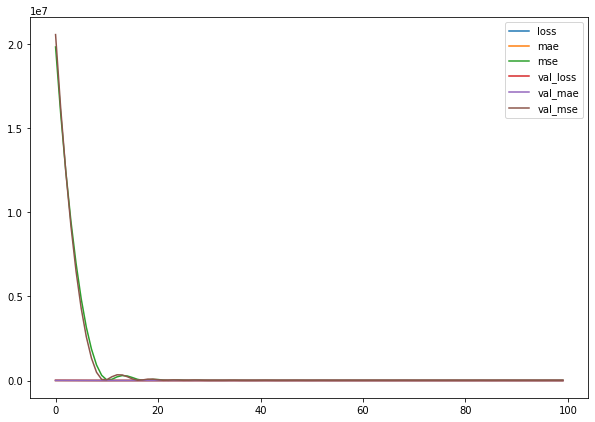

In [58]:
pd.DataFrame(history_0.history).plot(figsize=(10,7));

# 6 . Evaluate Model

In [59]:
# Evaluate model on test data
model_0.evaluate(test_windows, test_labels)

2/2 [==============================] - 0s 7ms/step - loss: 84.4302 - mae: 84.4302 - mse: 9824.9512


[84.4301528930664, 84.4301528930664, 9824.951171875]

# 7 . Load Saved Model

In [60]:
# Load in saved best performing model_1 and evaluate it on test data
model_0 = tf.keras.models.load_model("model_experiments/model_1_Dense/")
model_0.evaluate(test_windows, test_labels)

2/2 [==============================] - 0s 9ms/step - loss: 82.7720 - mae: 82.7720 - mse: 11051.7207


[82.77198028564453, 82.77198028564453, 11051.720703125]

# 8 . Make Predictions

In [61]:
def make_preds(model, input_data):
  """
  Uses model to make predictions input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [62]:
# Make predictions using model_1 on the test dataset and view results
model_0_preds = make_preds(model_0, test_windows) 
len(model_0_preds), model_0_preds[:10]

2/2 [==============================] - 0s 6ms/step


(49, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([4251.355 , 4247.3276, 4259.5664, 4300.518 , 4347.9897, 4356.03  ,
        4370.202 , 4408.7046, 4441.839 , 4469.1514], dtype=float32)>)

In [63]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shift of 1)

  return mae / mae_naive_no_season

In [64]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatype (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics 
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [65]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_0_preds)
model_1_results

{'mae': 82.77198,
 'mse': 11051.721,
 'rmse': 105.12717,
 'mape': 1.9008964,
 'mase': 1.6501942}

# 9 . Plot predictions

In [66]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

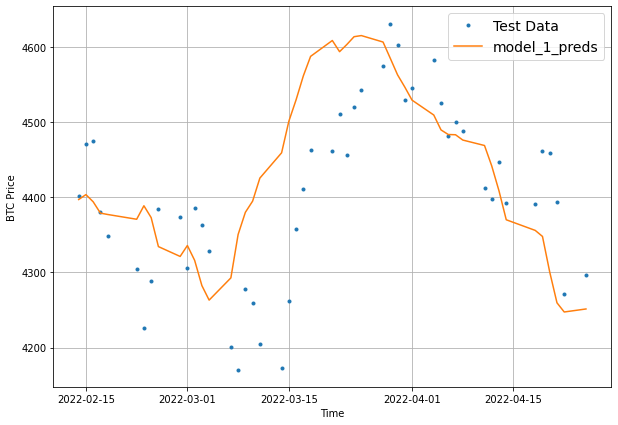

In [67]:
# Let's plot our model 1 predictions
offset = 0
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 label="Test Data")

plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_0_preds,
                 start=offset, 
                 format="-",
                 label="model_1_preds")

In [94]:
# 1. Create function to make predictions into the future
def make_future_forecasts(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Make future forecasts into_future steps after values ends.

  Returns future forecasts as a list of floats.
  """
  # 2. Create an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:]

  # 3. Make INTO_FUTURE numer of predictions, altering the data which gets predicted on each
  for _ in range(INTO_FUTURE):
    # Predict on the last window then append it again, again, again (our model will eventually start to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on:\n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [119]:
# Make forecasts into the future
INTO_FUTURE = 14
future_forecast = make_future_forecasts(values=prices,
                                        model=model_0,
                                        into_future=INTO_FUTURE,
                                        window_size=WINDOW_SIZE)

1/1 [==============================] - 0s 24ms/step
Predicting on:
 [4225.5  4304.76 4348.87 4380.26 4475.01 4471.07 4401.67] -> Prediction: 4397.3525390625

1/1 [==============================] - 0s 21ms/step
Predicting on:
 [4304.76       4348.87       4380.26       4475.01       4471.07
 4401.67       4397.35253906] -> Prediction: 4426.01513671875

1/1 [==============================] - 0s 23ms/step
Predicting on:
 [4348.87       4380.26       4475.01       4471.07       4401.67
 4397.35253906 4426.01513672] -> Prediction: 4455.6669921875

1/1 [==============================] - 0s 23ms/step
Predicting on:
 [4380.26       4475.01       4471.07       4401.67       4397.35253906
 4426.01513672 4455.66699219] -> Prediction: 4482.65966796875

1/1 [==============================] - 0s 29ms/step
Predicting on:
 [4475.01       4471.07       4401.67       4397.35253906 4426.01513672
 4455.66699219 4482.65966797] -> Prediction: 4503.0009765625

1/1 [==============================] - 0s 26ms/s

In [120]:
len(future_forecast)

14

In [121]:
def get_future_dates(start_date, into_future, offset=1):
  """
  Returns array of datetime values ranging from start_date to start_date+into_future
  """
  start_date = start_date + np.timedelta64(offset, "D") # specify start date, "D" stands for day
  end_date = start_date + np.timedelta64(into_future, "D") # specify end date
  return np.arange(start_date, end_date, dtype="datetime64[D]") # return a date range between start and end date

In [122]:
# Last timestep of timesteps (currently np.datetime64 format)
last_timestep = df.index[1]
last_timestep

Timestamp('2023-02-10 00:00:00')

In [123]:
# Get next two week of timesteps
next_time_steps = get_future_dates(start_date=last_timestep,
                                   into_future=INTO_FUTURE)
next_time_steps , next_time_steps.shape 

(array(['2023-02-11', '2023-02-12', '2023-02-13', '2023-02-14',
        '2023-02-15', '2023-02-16', '2023-02-17', '2023-02-18',
        '2023-02-19', '2023-02-20', '2023-02-21', '2023-02-22',
        '2023-02-23', '2023-02-24'], dtype='datetime64[D]'), (14,))

In [124]:
prices[-1]

4401.67

In [125]:
#Insert last timestep/final price into next time steps and future forecasts so the plot doesn't look janky
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, prices[-1])
next_time_steps.shape, future_forecast.shape

((15,), (15,))

In [126]:
next_time_steps.shape , future_forecast.shape

((15,), (15,))

In [131]:
future_forecast

array([4401.67  , 4397.3525, 4426.015 , 4455.667 , 4482.6597, 4503.001 ,
       4500.7603, 4494.822 , 4505.2837, 4523.8413, 4542.6206, 4558.099 ,
       4568.684 , 4575.3364, 4583.691 ], dtype=float32)

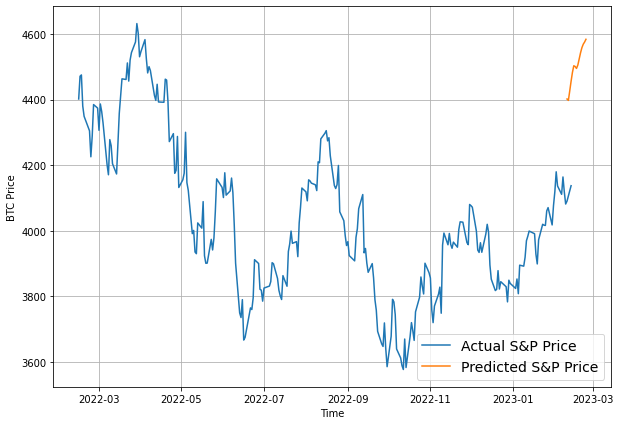

In [130]:
# Plot future prices predictions of Bitcoin
plt.figure(figsize=(10, 7))
plot_time_series(df.index, prices, format="-", label="Actual S&P Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted S&P Price")

# 10 . Normalize

In [140]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

train_windows_norm = scaler.fit_transform(train_windows)
test_windows_norm = scaler.transform(test_windows)

In [142]:
# Set random Seed
tf.random.set_seed(42)

# Build the model
model_norm = tf.keras.Sequential([
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(HORIZON,activation='linear')
],name='model_norm_Dense')

# Compile the model
model_norm.compile(loss = 'mae',
                optimizer = 'adam',
                metrics = ['mae','mse'])

# Fit the model 
history_norm = model_norm.fit(x=train_windows_norm,
                        y=train_labels,
                        epochs = 100,
                        batch_size=128,
                        validation_data=(test_windows_norm,test_labels),
                        callbacks = [create_model_checkpoint(model_name=model_norm.name)])

Epoch 1/100
1/2 [==============>...............] - ETA: 0s - loss: 3939.9243 - mae: 3939.9243 - mse: 15550027.0000

2/2 [==============================] - 1s 615ms/step - loss: 3940.3821 - mae: 3940.3821 - mse: 15553354.0000 - val_loss: 4401.2695 - val_mae: 4401.2695 - val_mse: 19384460.0000
Epoch 2/100
1/2 [==============>...............] - ETA: 0s - loss: 3935.7534 - mae: 3935.7534 - mse: 15518144.0000

2/2 [==============================] - 0s 428ms/step - loss: 3940.3020 - mae: 3940.3020 - mse: 15552710.0000 - val_loss: 4401.1089 - val_mae: 4401.1089 - val_mse: 19383042.0000
Epoch 3/100
1/2 [==============>...............] - ETA: 0s - loss: 3930.2151 - mae: 3930.2151 - mse: 15475224.0000

2/2 [==============================] - 0s 438ms/step - loss: 3940.2212 - mae: 3940.2212 - mse: 15552068.0000 - val_loss: 4400.9468 - val_mae: 4400.9468 - val_mse: 19381614.0000
Epoch 4/100
1/2 [==============>...............] - ETA: 0s - loss: 3934.9773 - mae: 3934.9773 - mse: 15506544.0000

2/2 [==============================] - 1s 708ms/step - loss: 3940.1392 - mae: 3940.1392 - mse: 15551416.0000 - val_loss: 4400.7837 - val_mae: 4400.7837 - val_mse: 19380170.0000
Epoch 5/100
1/2 [==============>...............] - ETA: 0s - loss: 3949.3433 - mae: 3949.3433 - mse: 15626644.0000

2/2 [==============================] - 0s 480ms/step - loss: 3940.0576 - mae: 3940.0576 - mse: 15550766.0000 - val_loss: 4400.6182 - val_mae: 4400.6182 - val_mse: 19378712.0000
Epoch 6/100
1/2 [==============>...............] - ETA: 0s - loss: 3951.3706 - mae: 3951.3706 - mse: 15640427.0000

2/2 [==============================] - 1s 666ms/step - loss: 3939.9736 - mae: 3939.9736 - mse: 15550098.0000 - val_loss: 4400.4502 - val_mae: 4400.4502 - val_mse: 19377236.0000
Epoch 7/100
1/2 [==============>...............] - ETA: 0s - loss: 3935.9741 - mae: 3935.9741 - mse: 15516369.0000

2/2 [==============================] - 1s 741ms/step - loss: 3939.8884 - mae: 3939.8884 - mse: 15549416.0000 - val_loss: 4400.2812 - val_mae: 4400.2812 - val_mse: 19375738.0000
Epoch 8/100
1/2 [==============>...............] - ETA: 0s - loss: 3942.7771 - mae: 3942.7771 - mse: 15575058.0000

2/2 [==============================] - 0s 465ms/step - loss: 3939.8022 - mae: 3939.8022 - mse: 15548732.0000 - val_loss: 4400.1084 - val_mae: 4400.1084 - val_mse: 19374218.0000
Epoch 9/100
1/2 [==============>...............] - ETA: 0s - loss: 3934.3562 - mae: 3934.3562 - mse: 15505758.0000

2/2 [==============================] - 0s 458ms/step - loss: 3939.7129 - mae: 3939.7129 - mse: 15548022.0000 - val_loss: 4399.9307 - val_mae: 4399.9307 - val_mse: 19372654.0000
Epoch 10/100
1/2 [==============>...............] - ETA: 0s - loss: 3945.8181 - mae: 3945.8181 - mse: 15597089.0000

2/2 [==============================] - 0s 442ms/step - loss: 3939.6218 - mae: 3939.6218 - mse: 15547294.0000 - val_loss: 4399.7476 - val_mae: 4399.7476 - val_mse: 19371034.0000
Epoch 11/100
1/2 [==============>...............] - ETA: 0s - loss: 3932.3091 - mae: 3932.3091 - mse: 15489189.0000

2/2 [==============================] - 0s 456ms/step - loss: 3939.5269 - mae: 3939.5269 - mse: 15546539.0000 - val_loss: 4399.5576 - val_mae: 4399.5576 - val_mse: 19369360.0000
Epoch 12/100
1/2 [==============>...............] - ETA: 0s - loss: 3947.5647 - mae: 3947.5647 - mse: 15607686.0000

2/2 [==============================] - 0s 432ms/step - loss: 3939.4294 - mae: 3939.4294 - mse: 15545763.0000 - val_loss: 4399.3599 - val_mae: 4399.3599 - val_mse: 19367624.0000
Epoch 13/100
1/2 [==============>...............] - ETA: 0s - loss: 3955.8250 - mae: 3955.8250 - mse: 15673730.0000

2/2 [==============================] - 0s 442ms/step - loss: 3939.3286 - mae: 3939.3286 - mse: 15544959.0000 - val_loss: 4399.1567 - val_mae: 4399.1567 - val_mse: 19365830.0000
Epoch 14/100
1/2 [==============>...............] - ETA: 0s - loss: 3944.5356 - mae: 3944.5356 - mse: 15585826.0000

2/2 [==============================] - 0s 444ms/step - loss: 3939.2244 - mae: 3939.2244 - mse: 15544131.0000 - val_loss: 4398.9463 - val_mae: 4398.9463 - val_mse: 19363978.0000
Epoch 15/100
1/2 [==============>...............] - ETA: 0s - loss: 3944.0344 - mae: 3944.0344 - mse: 15580070.0000

2/2 [==============================] - 0s 446ms/step - loss: 3939.1160 - mae: 3939.1160 - mse: 15543266.0000 - val_loss: 4398.7290 - val_mae: 4398.7290 - val_mse: 19362058.0000
Epoch 16/100
1/2 [==============>...............] - ETA: 0s - loss: 3930.7737 - mae: 3930.7737 - mse: 15479618.0000

2/2 [==============================] - 0s 440ms/step - loss: 3939.0022 - mae: 3939.0022 - mse: 15542361.0000 - val_loss: 4398.5024 - val_mae: 4398.5024 - val_mse: 19360062.0000
Epoch 17/100
1/2 [==============>...............] - ETA: 0s - loss: 3942.1899 - mae: 3942.1899 - mse: 15570377.0000

2/2 [==============================] - 1s 607ms/step - loss: 3938.8860 - mae: 3938.8860 - mse: 15541434.0000 - val_loss: 4398.2666 - val_mae: 4398.2666 - val_mse: 19357984.0000
Epoch 18/100
1/2 [==============>...............] - ETA: 0s - loss: 3930.8491 - mae: 3930.8491 - mse: 15479822.0000

2/2 [==============================] - 1s 1s/step - loss: 3938.7642 - mae: 3938.7642 - mse: 15540468.0000 - val_loss: 4398.0215 - val_mae: 4398.0215 - val_mse: 19355824.0000
Epoch 19/100
1/2 [==============>...............] - ETA: 0s - loss: 3934.0828 - mae: 3934.0828 - mse: 15502488.0000

2/2 [==============================] - 1s 718ms/step - loss: 3938.6382 - mae: 3938.6382 - mse: 15539461.0000 - val_loss: 4397.7671 - val_mae: 4397.7671 - val_mse: 19353580.0000
Epoch 20/100
1/2 [==============>...............] - ETA: 0s - loss: 3932.6545 - mae: 3932.6545 - mse: 15492242.0000

2/2 [==============================] - 1s 693ms/step - loss: 3938.5071 - mae: 3938.5071 - mse: 15538418.0000 - val_loss: 4397.5039 - val_mae: 4397.5039 - val_mse: 19351260.0000
Epoch 21/100
1/2 [==============>...............] - ETA: 0s - loss: 3950.9038 - mae: 3950.9038 - mse: 15637204.0000

2/2 [==============================] - 1s 1s/step - loss: 3938.3743 - mae: 3938.3743 - mse: 15537363.0000 - val_loss: 4397.2310 - val_mae: 4397.2310 - val_mse: 19348858.0000
Epoch 22/100
1/2 [==============>...............] - ETA: 0s - loss: 3917.4653 - mae: 3917.4653 - mse: 15371814.0000

2/2 [==============================] - 0s 463ms/step - loss: 3938.2312 - mae: 3938.2312 - mse: 15536220.0000 - val_loss: 4396.9507 - val_mae: 4396.9507 - val_mse: 19346388.0000
Epoch 23/100
1/2 [==============>...............] - ETA: 0s - loss: 3933.2988 - mae: 3933.2988 - mse: 15496762.0000

2/2 [==============================] - 1s 1s/step - loss: 3938.0872 - mae: 3938.0872 - mse: 15535075.0000 - val_loss: 4396.6597 - val_mae: 4396.6597 - val_mse: 19343820.0000
Epoch 24/100
1/2 [==============>...............] - ETA: 0s - loss: 3932.2046 - mae: 3932.2046 - mse: 15491245.0000

2/2 [==============================] - 1s 600ms/step - loss: 3937.9346 - mae: 3937.9346 - mse: 15533859.0000 - val_loss: 4396.3560 - val_mae: 4396.3560 - val_mse: 19341144.0000
Epoch 25/100
1/2 [==============>...............] - ETA: 0s - loss: 3946.1553 - mae: 3946.1553 - mse: 15597623.0000

2/2 [==============================] - 1s 847ms/step - loss: 3937.7795 - mae: 3937.7795 - mse: 15532624.0000 - val_loss: 4396.0396 - val_mae: 4396.0396 - val_mse: 19338360.0000
Epoch 26/100
1/2 [==============>...............] - ETA: 0s - loss: 3933.4045 - mae: 3933.4045 - mse: 15497450.0000

2/2 [==============================] - 1s 682ms/step - loss: 3937.6155 - mae: 3937.6155 - mse: 15531318.0000 - val_loss: 4395.7129 - val_mae: 4395.7129 - val_mse: 19335480.0000
Epoch 27/100
1/2 [==============>...............] - ETA: 0s - loss: 3935.7019 - mae: 3935.7019 - mse: 15517181.0000

2/2 [==============================] - 1s 1s/step - loss: 3937.4485 - mae: 3937.4485 - mse: 15529989.0000 - val_loss: 4395.3755 - val_mae: 4395.3755 - val_mse: 19332510.0000
Epoch 28/100
1/2 [==============>...............] - ETA: 0s - loss: 3929.0942 - mae: 3929.0942 - mse: 15463657.0000

2/2 [==============================] - 1s 944ms/step - loss: 3937.2732 - mae: 3937.2732 - mse: 15528594.0000 - val_loss: 4395.0288 - val_mae: 4395.0288 - val_mse: 19329452.0000
Epoch 29/100
1/2 [==============>...............] - ETA: 0s - loss: 3932.0918 - mae: 3932.0918 - mse: 15487947.0000

2/2 [==============================] - 2s 2s/step - loss: 3937.0940 - mae: 3937.0940 - mse: 15527169.0000 - val_loss: 4394.6704 - val_mae: 4394.6704 - val_mse: 19326302.0000
Epoch 30/100
1/2 [==============>...............] - ETA: 0s - loss: 3946.1965 - mae: 3946.1965 - mse: 15596900.0000

2/2 [==============================] - 2s 2s/step - loss: 3936.9121 - mae: 3936.9121 - mse: 15525723.0000 - val_loss: 4394.3018 - val_mae: 4394.3018 - val_mse: 19323052.0000
Epoch 31/100
1/2 [==============>...............] - ETA: 0s - loss: 3952.5278 - mae: 3952.5278 - mse: 15652276.0000

2/2 [==============================] - 1s 1s/step - loss: 3936.7236 - mae: 3936.7236 - mse: 15524226.0000 - val_loss: 4393.9229 - val_mae: 4393.9229 - val_mse: 19319714.0000
Epoch 32/100
1/2 [==============>...............] - ETA: 0s - loss: 3945.8135 - mae: 3945.8135 - mse: 15597387.0000

2/2 [==============================] - 2s 2s/step - loss: 3936.5291 - mae: 3936.5291 - mse: 15522676.0000 - val_loss: 4393.5337 - val_mae: 4393.5337 - val_mse: 19316290.0000
Epoch 33/100
1/2 [==============>...............] - ETA: 0s - loss: 3934.3398 - mae: 3934.3398 - mse: 15502735.0000

2/2 [==============================] - 1s 710ms/step - loss: 3936.3281 - mae: 3936.3281 - mse: 15521073.0000 - val_loss: 4393.1338 - val_mae: 4393.1338 - val_mse: 19312774.0000
Epoch 34/100
1/2 [==============>...............] - ETA: 0s - loss: 3937.4612 - mae: 3937.4612 - mse: 15529824.0000

2/2 [==============================] - 1s 917ms/step - loss: 3936.1199 - mae: 3936.1199 - mse: 15519421.0000 - val_loss: 4392.7236 - val_mae: 4392.7236 - val_mse: 19309164.0000
Epoch 35/100
1/2 [==============>...............] - ETA: 0s - loss: 3941.6006 - mae: 3941.6006 - mse: 15562404.0000

2/2 [==============================] - 1s 1s/step - loss: 3935.9121 - mae: 3935.9121 - mse: 15517764.0000 - val_loss: 4392.3018 - val_mae: 4392.3018 - val_mse: 19305446.0000
Epoch 36/100
1/2 [==============>...............] - ETA: 0s - loss: 3940.2769 - mae: 3940.2769 - mse: 15553588.0000

2/2 [==============================] - 1s 829ms/step - loss: 3935.6943 - mae: 3935.6943 - mse: 15516031.0000 - val_loss: 4391.8691 - val_mae: 4391.8691 - val_mse: 19301638.0000
Epoch 37/100
1/2 [==============>...............] - ETA: 0s - loss: 3929.4412 - mae: 3929.4412 - mse: 15467325.0000

2/2 [==============================] - 0s 433ms/step - loss: 3935.4709 - mae: 3935.4709 - mse: 15514254.0000 - val_loss: 4391.4248 - val_mae: 4391.4248 - val_mse: 19297726.0000
Epoch 38/100
1/2 [==============>...............] - ETA: 0s - loss: 3936.7920 - mae: 3936.7920 - mse: 15523594.0000

2/2 [==============================] - 0s 470ms/step - loss: 3935.2429 - mae: 3935.2429 - mse: 15512441.0000 - val_loss: 4390.9688 - val_mae: 4390.9688 - val_mse: 19293714.0000
Epoch 39/100
1/2 [==============>...............] - ETA: 0s - loss: 3941.1541 - mae: 3941.1541 - mse: 15556835.0000

2/2 [==============================] - 0s 448ms/step - loss: 3935.0095 - mae: 3935.0095 - mse: 15510587.0000 - val_loss: 4390.5010 - val_mae: 4390.5010 - val_mse: 19289602.0000
Epoch 40/100
1/2 [==============>...............] - ETA: 0s - loss: 3947.3264 - mae: 3947.3264 - mse: 15606473.0000

2/2 [==============================] - 0s 457ms/step - loss: 3934.7698 - mae: 3934.7698 - mse: 15508680.0000 - val_loss: 4390.0229 - val_mae: 4390.0229 - val_mse: 19285392.0000
Epoch 41/100
1/2 [==============>...............] - ETA: 0s - loss: 3936.7778 - mae: 3936.7778 - mse: 15524557.0000

2/2 [==============================] - 0s 420ms/step - loss: 3934.5227 - mae: 3934.5227 - mse: 15506714.0000 - val_loss: 4389.5337 - val_mae: 4389.5337 - val_mse: 19281084.0000
Epoch 42/100
1/2 [==============>...............] - ETA: 0s - loss: 3935.3877 - mae: 3935.3877 - mse: 15513342.0000

2/2 [==============================] - 0s 435ms/step - loss: 3934.2725 - mae: 3934.2725 - mse: 15504723.0000 - val_loss: 4389.0317 - val_mae: 4389.0317 - val_mse: 19276674.0000
Epoch 43/100
1/2 [==============>...............] - ETA: 0s - loss: 3946.8359 - mae: 3946.8359 - mse: 15606167.0000

2/2 [==============================] - 0s 419ms/step - loss: 3934.0164 - mae: 3934.0164 - mse: 15502688.0000 - val_loss: 4388.5190 - val_mae: 4388.5190 - val_mse: 19272166.0000
Epoch 44/100
1/2 [==============>...............] - ETA: 0s - loss: 3926.2607 - mae: 3926.2607 - mse: 15440428.0000

2/2 [==============================] - 0s 468ms/step - loss: 3933.7500 - mae: 3933.7500 - mse: 15500566.0000 - val_loss: 4387.9956 - val_mae: 4387.9956 - val_mse: 19267564.0000
Epoch 45/100
1/2 [==============>...............] - ETA: 0s - loss: 3937.7849 - mae: 3937.7849 - mse: 15531193.0000

2/2 [==============================] - 0s 442ms/step - loss: 3933.4827 - mae: 3933.4827 - mse: 15498442.0000 - val_loss: 4387.4600 - val_mae: 4387.4600 - val_mse: 19262850.0000
Epoch 46/100
1/2 [==============>...............] - ETA: 0s - loss: 3942.8232 - mae: 3942.8232 - mse: 15572865.0000

2/2 [==============================] - 1s 530ms/step - loss: 3933.2092 - mae: 3933.2092 - mse: 15496271.0000 - val_loss: 4386.9126 - val_mae: 4386.9126 - val_mse: 19258038.0000
Epoch 47/100
1/2 [==============>...............] - ETA: 0s - loss: 3932.5596 - mae: 3932.5596 - mse: 15491303.0000

2/2 [==============================] - 1s 630ms/step - loss: 3932.9246 - mae: 3932.9246 - mse: 15494007.0000 - val_loss: 4386.3545 - val_mae: 4386.3545 - val_mse: 19253134.0000
Epoch 48/100
1/2 [==============>...............] - ETA: 0s - loss: 3946.7832 - mae: 3946.7832 - mse: 15605116.0000

2/2 [==============================] - 1s 986ms/step - loss: 3932.6406 - mae: 3932.6406 - mse: 15491755.0000 - val_loss: 4385.7832 - val_mae: 4385.7832 - val_mse: 19248114.0000
Epoch 49/100
1/2 [==============>...............] - ETA: 0s - loss: 3919.5273 - mae: 3919.5273 - mse: 15389632.0000

2/2 [==============================] - 1s 526ms/step - loss: 3932.3440 - mae: 3932.3440 - mse: 15489389.0000 - val_loss: 4385.2007 - val_mae: 4385.2007 - val_mse: 19243000.0000
Epoch 50/100
1/2 [==============>...............] - ETA: 0s - loss: 3927.8540 - mae: 3927.8540 - mse: 15452318.0000

2/2 [==============================] - 0s 427ms/step - loss: 3932.0461 - mae: 3932.0461 - mse: 15487022.0000 - val_loss: 4384.6060 - val_mae: 4384.6060 - val_mse: 19237768.0000
Epoch 51/100
1/2 [==============>...............] - ETA: 0s - loss: 3950.8486 - mae: 3950.8486 - mse: 15636773.0000

2/2 [==============================] - 0s 460ms/step - loss: 3931.7432 - mae: 3931.7432 - mse: 15484621.0000 - val_loss: 4383.9980 - val_mae: 4383.9980 - val_mse: 19232432.0000
Epoch 52/100
1/2 [==============>...............] - ETA: 0s - loss: 3928.3064 - mae: 3928.3064 - mse: 15455991.0000

2/2 [==============================] - 0s 448ms/step - loss: 3931.4302 - mae: 3931.4302 - mse: 15482128.0000 - val_loss: 4383.3789 - val_mae: 4383.3789 - val_mse: 19226994.0000
Epoch 53/100
1/2 [==============>...............] - ETA: 0s - loss: 3927.1650 - mae: 3927.1650 - mse: 15447965.0000

2/2 [==============================] - 0s 464ms/step - loss: 3931.1104 - mae: 3931.1104 - mse: 15479587.0000 - val_loss: 4382.7485 - val_mae: 4382.7485 - val_mse: 19221454.0000
Epoch 54/100
1/2 [==============>...............] - ETA: 0s - loss: 3929.2036 - mae: 3929.2036 - mse: 15466386.0000

2/2 [==============================] - 0s 429ms/step - loss: 3930.7886 - mae: 3930.7886 - mse: 15477027.0000 - val_loss: 4382.1045 - val_mae: 4382.1045 - val_mse: 19215802.0000
Epoch 55/100
1/2 [==============>...............] - ETA: 0s - loss: 3925.6145 - mae: 3925.6145 - mse: 15438290.0000

2/2 [==============================] - 0s 461ms/step - loss: 3930.4558 - mae: 3930.4558 - mse: 15474389.0000 - val_loss: 4381.4492 - val_mae: 4381.4492 - val_mse: 19210042.0000
Epoch 56/100
1/2 [==============>...............] - ETA: 0s - loss: 3926.4189 - mae: 3926.4189 - mse: 15439879.0000

2/2 [==============================] - 0s 453ms/step - loss: 3930.1191 - mae: 3930.1191 - mse: 15471713.0000 - val_loss: 4380.7798 - val_mae: 4380.7798 - val_mse: 19204170.0000
Epoch 57/100
1/2 [==============>...............] - ETA: 0s - loss: 3943.9258 - mae: 3943.9258 - mse: 15581270.0000

2/2 [==============================] - 0s 436ms/step - loss: 3929.7798 - mae: 3929.7798 - mse: 15469022.0000 - val_loss: 4380.0981 - val_mae: 4380.0981 - val_mse: 19198188.0000
Epoch 58/100
1/2 [==============>...............] - ETA: 0s - loss: 3916.7729 - mae: 3916.7729 - mse: 15366591.0000

2/2 [==============================] - 0s 438ms/step - loss: 3929.4270 - mae: 3929.4270 - mse: 15466212.0000 - val_loss: 4379.4058 - val_mae: 4379.4058 - val_mse: 19192108.0000
Epoch 59/100
1/2 [==============>...............] - ETA: 0s - loss: 3931.1201 - mae: 3931.1201 - mse: 15479052.0000

2/2 [==============================] - 0s 434ms/step - loss: 3929.0708 - mae: 3929.0708 - mse: 15463387.0000 - val_loss: 4378.7002 - val_mae: 4378.7002 - val_mse: 19185920.0000
Epoch 60/100
1/2 [==============>...............] - ETA: 0s - loss: 3924.4766 - mae: 3924.4766 - mse: 15428397.0000

2/2 [==============================] - 0s 475ms/step - loss: 3928.7092 - mae: 3928.7092 - mse: 15460517.0000 - val_loss: 4377.9819 - val_mae: 4377.9819 - val_mse: 19179616.0000
Epoch 61/100
1/2 [==============>...............] - ETA: 0s - loss: 3934.8628 - mae: 3934.8628 - mse: 15509427.0000

2/2 [==============================] - 0s 432ms/step - loss: 3928.3425 - mae: 3928.3425 - mse: 15457608.0000 - val_loss: 4377.2505 - val_mae: 4377.2505 - val_mse: 19173200.0000
Epoch 62/100
1/2 [==============>...............] - ETA: 0s - loss: 3928.9722 - mae: 3928.9722 - mse: 15463096.0000

2/2 [==============================] - 1s 730ms/step - loss: 3927.9666 - mae: 3927.9666 - mse: 15454623.0000 - val_loss: 4376.5078 - val_mae: 4376.5078 - val_mse: 19166686.0000
Epoch 63/100
1/2 [==============>...............] - ETA: 0s - loss: 3942.5461 - mae: 3942.5461 - mse: 15570553.0000

2/2 [==============================] - 0s 455ms/step - loss: 3927.5881 - mae: 3927.5881 - mse: 15451622.0000 - val_loss: 4375.7520 - val_mae: 4375.7520 - val_mse: 19160058.0000
Epoch 64/100
1/2 [==============>...............] - ETA: 0s - loss: 3930.6248 - mae: 3930.6248 - mse: 15474691.0000

2/2 [==============================] - 0s 440ms/step - loss: 3927.1980 - mae: 3927.1980 - mse: 15448521.0000 - val_loss: 4374.9849 - val_mae: 4374.9849 - val_mse: 19153330.0000
Epoch 65/100
1/2 [==============>...............] - ETA: 0s - loss: 3928.8198 - mae: 3928.8198 - mse: 15461300.0000

2/2 [==============================] - 0s 429ms/step - loss: 3926.8071 - mae: 3926.8071 - mse: 15445420.0000 - val_loss: 4374.2036 - val_mae: 4374.2036 - val_mse: 19146488.0000
Epoch 66/100
1/2 [==============>...............] - ETA: 0s - loss: 3930.9509 - mae: 3930.9509 - mse: 15477147.0000

2/2 [==============================] - 0s 444ms/step - loss: 3926.4065 - mae: 3926.4065 - mse: 15442238.0000 - val_loss: 4373.4111 - val_mae: 4373.4111 - val_mse: 19139544.0000
Epoch 67/100
1/2 [==============>...............] - ETA: 0s - loss: 3934.4656 - mae: 3934.4656 - mse: 15506350.0000

2/2 [==============================] - 0s 428ms/step - loss: 3925.9980 - mae: 3925.9980 - mse: 15439000.0000 - val_loss: 4372.6074 - val_mae: 4372.6074 - val_mse: 19132496.0000
Epoch 68/100
1/2 [==============>...............] - ETA: 0s - loss: 3923.9241 - mae: 3923.9241 - mse: 15421581.0000

2/2 [==============================] - 0s 444ms/step - loss: 3925.5859 - mae: 3925.5859 - mse: 15435727.0000 - val_loss: 4371.7896 - val_mae: 4371.7896 - val_mse: 19125332.0000
Epoch 69/100
1/2 [==============>...............] - ETA: 0s - loss: 3919.4724 - mae: 3919.4724 - mse: 15387518.0000

2/2 [==============================] - 0s 436ms/step - loss: 3925.1650 - mae: 3925.1650 - mse: 15432388.0000 - val_loss: 4370.9585 - val_mae: 4370.9585 - val_mse: 19118056.0000
Epoch 70/100
1/2 [==============>...............] - ETA: 0s - loss: 3921.3762 - mae: 3921.3762 - mse: 15401860.0000

2/2 [==============================] - 1s 562ms/step - loss: 3924.7371 - mae: 3924.7371 - mse: 15428994.0000 - val_loss: 4370.1143 - val_mae: 4370.1143 - val_mse: 19110660.0000
Epoch 71/100
1/2 [==============>...............] - ETA: 0s - loss: 3931.9705 - mae: 3931.9705 - mse: 15485910.0000

2/2 [==============================] - 1s 605ms/step - loss: 3924.3096 - mae: 3924.3096 - mse: 15425606.0000 - val_loss: 4369.2549 - val_mae: 4369.2549 - val_mse: 19103140.0000
Epoch 72/100
1/2 [==============>...............] - ETA: 0s - loss: 3923.6099 - mae: 3923.6099 - mse: 15419235.0000

2/2 [==============================] - 1s 647ms/step - loss: 3923.8669 - mae: 3923.8669 - mse: 15422096.0000 - val_loss: 4368.3848 - val_mae: 4368.3848 - val_mse: 19095520.0000
Epoch 73/100
1/2 [==============>...............] - ETA: 0s - loss: 3931.0811 - mae: 3931.0811 - mse: 15481708.0000

2/2 [==============================] - 1s 615ms/step - loss: 3923.4221 - mae: 3923.4221 - mse: 15418571.0000 - val_loss: 4367.5020 - val_mae: 4367.5020 - val_mse: 19087794.0000
Epoch 74/100
1/2 [==============>...............] - ETA: 0s - loss: 3931.2461 - mae: 3931.2461 - mse: 15480621.0000

2/2 [==============================] - 0s 445ms/step - loss: 3922.9692 - mae: 3922.9692 - mse: 15414981.0000 - val_loss: 4366.6064 - val_mae: 4366.6064 - val_mse: 19079960.0000
Epoch 75/100
1/2 [==============>...............] - ETA: 0s - loss: 3925.3877 - mae: 3925.3877 - mse: 15435275.0000

2/2 [==============================] - 0s 449ms/step - loss: 3922.5090 - mae: 3922.5090 - mse: 15411333.0000 - val_loss: 4365.6992 - val_mae: 4365.6992 - val_mse: 19072020.0000
Epoch 76/100
1/2 [==============>...............] - ETA: 0s - loss: 3920.4658 - mae: 3920.4658 - mse: 15397994.0000

2/2 [==============================] - 1s 731ms/step - loss: 3922.0403 - mae: 3922.0403 - mse: 15407613.0000 - val_loss: 4364.7783 - val_mae: 4364.7783 - val_mse: 19063968.0000
Epoch 77/100
1/2 [==============>...............] - ETA: 0s - loss: 3924.7729 - mae: 3924.7729 - mse: 15430731.0000

2/2 [==============================] - 0s 447ms/step - loss: 3921.5715 - mae: 3921.5715 - mse: 15403899.0000 - val_loss: 4363.8433 - val_mae: 4363.8433 - val_mse: 19055788.0000
Epoch 78/100
1/2 [==============>...............] - ETA: 0s - loss: 3933.8623 - mae: 3933.8623 - mse: 15498538.0000

2/2 [==============================] - 0s 436ms/step - loss: 3921.0935 - mae: 3921.0935 - mse: 15400115.0000 - val_loss: 4362.8945 - val_mae: 4362.8945 - val_mse: 19047498.0000
Epoch 79/100
1/2 [==============>...............] - ETA: 0s - loss: 3911.6609 - mae: 3911.6609 - mse: 15323578.0000

2/2 [==============================] - 0s 445ms/step - loss: 3920.6018 - mae: 3920.6018 - mse: 15396215.0000 - val_loss: 4361.9341 - val_mae: 4361.9341 - val_mse: 19039102.0000
Epoch 80/100
1/2 [==============>...............] - ETA: 0s - loss: 3920.8005 - mae: 3920.8005 - mse: 15399524.0000

2/2 [==============================] - 0s 441ms/step - loss: 3920.1135 - mae: 3920.1135 - mse: 15392351.0000 - val_loss: 4360.9595 - val_mae: 4360.9595 - val_mse: 19030580.0000
Epoch 81/100
1/2 [==============>...............] - ETA: 0s - loss: 3920.6875 - mae: 3920.6875 - mse: 15398046.0000

2/2 [==============================] - 0s 440ms/step - loss: 3919.6155 - mae: 3919.6155 - mse: 15388407.0000 - val_loss: 4359.9722 - val_mae: 4359.9722 - val_mse: 19021952.0000
Epoch 82/100
1/2 [==============>...............] - ETA: 0s - loss: 3924.0713 - mae: 3924.0713 - mse: 15422630.0000

2/2 [==============================] - 0s 430ms/step - loss: 3919.1084 - mae: 3919.1084 - mse: 15384390.0000 - val_loss: 4358.9722 - val_mae: 4358.9722 - val_mse: 19013224.0000
Epoch 83/100
1/2 [==============>...............] - ETA: 0s - loss: 3910.3713 - mae: 3910.3713 - mse: 15316607.0000

2/2 [==============================] - 0s 455ms/step - loss: 3918.5881 - mae: 3918.5881 - mse: 15380267.0000 - val_loss: 4357.9604 - val_mae: 4357.9604 - val_mse: 19004388.0000
Epoch 84/100
1/2 [==============>...............] - ETA: 0s - loss: 3924.7612 - mae: 3924.7612 - mse: 15428920.0000

2/2 [==============================] - 0s 464ms/step - loss: 3918.0796 - mae: 3918.0796 - mse: 15376245.0000 - val_loss: 4356.9316 - val_mae: 4356.9316 - val_mse: 18995406.0000
Epoch 85/100
1/2 [==============>...............] - ETA: 0s - loss: 3915.4429 - mae: 3915.4429 - mse: 15355004.0000

2/2 [==============================] - 0s 428ms/step - loss: 3917.5515 - mae: 3917.5515 - mse: 15372062.0000 - val_loss: 4355.8931 - val_mae: 4355.8931 - val_mse: 18986340.0000
Epoch 86/100
1/2 [==============>...............] - ETA: 0s - loss: 3917.6062 - mae: 3917.6062 - mse: 15372906.0000

2/2 [==============================] - 0s 460ms/step - loss: 3917.0173 - mae: 3917.0173 - mse: 15367836.0000 - val_loss: 4354.8423 - val_mae: 4354.8423 - val_mse: 18977168.0000
Epoch 87/100
1/2 [==============>...............] - ETA: 0s - loss: 3909.3452 - mae: 3909.3452 - mse: 15307745.0000

2/2 [==============================] - 0s 432ms/step - loss: 3916.4736 - mae: 3916.4736 - mse: 15363531.0000 - val_loss: 4353.7788 - val_mae: 4353.7788 - val_mse: 18967890.0000
Epoch 88/100
1/2 [==============>...............] - ETA: 0s - loss: 3902.4236 - mae: 3902.4236 - mse: 15253220.0000

2/2 [==============================] - 0s 475ms/step - loss: 3915.9282 - mae: 3915.9282 - mse: 15359210.0000 - val_loss: 4352.6997 - val_mae: 4352.6997 - val_mse: 18958478.0000
Epoch 89/100
1/2 [==============>...............] - ETA: 0s - loss: 3914.4094 - mae: 3914.4094 - mse: 15346375.0000

2/2 [==============================] - 0s 460ms/step - loss: 3915.3794 - mae: 3915.3794 - mse: 15354873.0000 - val_loss: 4351.6055 - val_mae: 4351.6055 - val_mse: 18948936.0000
Epoch 90/100
1/2 [==============>...............] - ETA: 0s - loss: 3914.4243 - mae: 3914.4243 - mse: 15347245.0000

2/2 [==============================] - 0s 433ms/step - loss: 3914.8159 - mae: 3914.8159 - mse: 15350415.0000 - val_loss: 4350.4985 - val_mae: 4350.4985 - val_mse: 18939288.0000
Epoch 91/100
1/2 [==============>...............] - ETA: 0s - loss: 3927.0044 - mae: 3927.0044 - mse: 15448170.0000

2/2 [==============================] - 1s 734ms/step - loss: 3914.2551 - mae: 3914.2551 - mse: 15345988.0000 - val_loss: 4349.3779 - val_mae: 4349.3779 - val_mse: 18929520.0000
Epoch 92/100
1/2 [==============>...............] - ETA: 0s - loss: 3914.0483 - mae: 3914.0483 - mse: 15347861.0000

2/2 [==============================] - 0s 457ms/step - loss: 3913.6772 - mae: 3913.6772 - mse: 15341414.0000 - val_loss: 4348.2466 - val_mae: 4348.2466 - val_mse: 18919664.0000
Epoch 93/100
1/2 [==============>...............] - ETA: 0s - loss: 3924.7192 - mae: 3924.7192 - mse: 15429290.0000

2/2 [==============================] - 0s 449ms/step - loss: 3913.1028 - mae: 3913.1028 - mse: 15336877.0000 - val_loss: 4347.1021 - val_mae: 4347.1021 - val_mse: 18909694.0000
Epoch 94/100
1/2 [==============>...............] - ETA: 0s - loss: 3910.9077 - mae: 3910.9077 - mse: 15320048.0000

2/2 [==============================] - 1s 639ms/step - loss: 3912.5173 - mae: 3912.5173 - mse: 15332239.0000 - val_loss: 4345.9473 - val_mae: 4345.9473 - val_mse: 18899638.0000
Epoch 95/100
1/2 [==============>...............] - ETA: 0s - loss: 3895.5874 - mae: 3895.5874 - mse: 15198865.0000

2/2 [==============================] - 1s 655ms/step - loss: 3911.9153 - mae: 3911.9153 - mse: 15327480.0000 - val_loss: 4344.7817 - val_mae: 4344.7817 - val_mse: 18889488.0000
Epoch 96/100
1/2 [==============>...............] - ETA: 0s - loss: 3889.2712 - mae: 3889.2712 - mse: 15151308.0000

2/2 [==============================] - 1s 656ms/step - loss: 3911.3147 - mae: 3911.3147 - mse: 15322732.0000 - val_loss: 4343.5996 - val_mae: 4343.5996 - val_mse: 18879198.0000
Epoch 97/100
1/2 [==============>...............] - ETA: 0s - loss: 3901.4307 - mae: 3901.4307 - mse: 15242873.0000

2/2 [==============================] - 1s 509ms/step - loss: 3910.7129 - mae: 3910.7129 - mse: 15317979.0000 - val_loss: 4342.3999 - val_mae: 4342.3999 - val_mse: 18868764.0000
Epoch 98/100
1/2 [==============>...............] - ETA: 0s - loss: 3909.8279 - mae: 3909.8279 - mse: 15310109.0000

2/2 [==============================] - 0s 441ms/step - loss: 3910.1057 - mae: 3910.1057 - mse: 15313189.0000 - val_loss: 4341.1870 - val_mae: 4341.1870 - val_mse: 18858208.0000
Epoch 99/100
1/2 [==============>...............] - ETA: 0s - loss: 3922.2419 - mae: 3922.2419 - mse: 15406919.0000

2/2 [==============================] - 0s 428ms/step - loss: 3909.4895 - mae: 3909.4895 - mse: 15308321.0000 - val_loss: 4339.9629 - val_mae: 4339.9629 - val_mse: 18847566.0000
Epoch 100/100
1/2 [==============>...............] - ETA: 0s - loss: 3911.2742 - mae: 3911.2742 - mse: 15323260.0000

2/2 [==============================] - 0s 420ms/step - loss: 3908.8569 - mae: 3908.8569 - mse: 15303328.0000 - val_loss: 4338.7310 - val_mae: 4338.7310 - val_mse: 18836854.0000


In [143]:
model_norm.evaluate(test_windows_norm,test_labels)

2/2 [==============================] - 0s 9ms/step - loss: 4338.7310 - mae: 4338.7310 - mse: 18836854.0000


[4338.73095703125, 4338.73095703125, 18836854.0]